In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.patches as patches
# import qutip as qt
from tqdm.notebook import tqdm
import math

In [3]:
def power_to_kappa(power, kappa=0.1):
    power2 = np.array(power)
    power2 -= 49.6 # splitters and attenuation
    power2 = np.sqrt(10**((power2)/10)*0.001*50) # power to RMS voltage
    power2 *= 2*np.sqrt(2) # RMS to p2p voltage
    power2 *= (84.34 + 73.44) # polariton rabi rates in MHz
    power2 /= kappa
    return power2

# No Blockade

## Data

In [4]:
df = pd.read_csv(f'..\\experiment_data\\bus-Q4-pns_34.csv')
df1 = pd.read_csv(f'..\\experiment_data\\bus-Q4-pns_35.csv')
power = np.array(np.unique(df['power']))
power1 = np.array(np.unique(df1['power']))
powerc = np.concatenate([power, power1])
freqs = np.array(np.unique(df['frequency']))
phase = np.flip(np.unwrap(np.array(df['phase']).reshape([len(power), len(freqs)])), axis=0)
phase1 = np.flip(np.unwrap(np.array(df1['phase']).reshape([len(power1), len(freqs)])), axis=0)
phasec = np.concatenate([phase, phase1])
phasec = phasec.transpose()
phasec = phasec - np.mean(phasec, axis=0)

In [5]:
xdata0 = powerc
ydata0 = freqs
zdata0 = phasec

In [6]:
chi = 35
kappa = 422
sz0 = (kappa/(2*chi))*(np.cos(zdata0) - 1)/(np.sin(zdata0))
sz0 = 0.5*(sz0-np.min(sz0))

In [7]:
fs0 = np.zeros([len(xdata0), 6])
hs0 = np.zeros([len(xdata0), 6])
alpha_est = np.zeros(len(xdata0))
for i in range(len(xdata0)):
    # y = zdata0[:, i]
    y = sz0[:, i] - np.min(sz0[:,i])
    y = scipy.signal.savgol_filter(y, 21, 3)
    pks, props = scipy.signal.find_peaks(y, height=0.023, width=10)
    proms = props['prominences']
    if len(proms) > 2:
        if props['left_bases'][1] == props['left_bases'][2]:
            proms[1], proms[2] = proms[2], proms[1]
            print('swapped')
    for j in range(np.min([5, len(pks)])):
        fs0[i, j] = freqs[pks[j]]
        hs0[i, j] = proms[j]
    hs0[i, :] = (hs0[i, :])/np.sum(hs0[i, :])
    alpha_est[i] = np.sum(hs0[i,:]*np.arange(6))

swapped
swapped


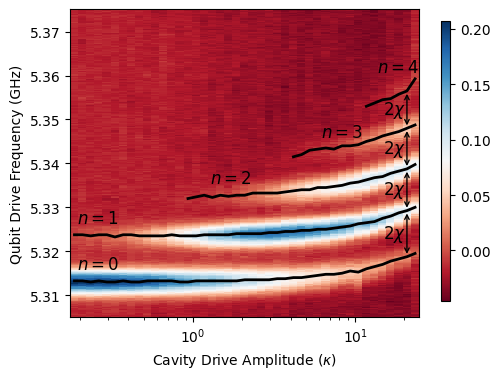

In [8]:
fig, ax = plt.subplots(figsize=(4.5,4))
test = ax.pcolor(power_to_kappa(xdata0), ydata0/1e9, -zdata0, cmap='RdBu')
cbaxes = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(test, ax=ax, cax=cbaxes)
for i in range(fs0.shape[1]-1):
    y = []
    powt = []
    for j in range(fs0.shape[0]):
        if fs0[j,i] > 0.1:
            y.append(fs0[j,i]/1e9)
            powt.append(xdata0[j])
    if i > 0:
        xs = power_to_kappa([13.,16.])
        p1 = patches.FancyArrowPatch((xs[1], ylast[-2]), (xs[1], y[-2]), arrowstyle='<->', mutation_scale=8)
        ax.annotate("$2\chi$", xy=(xs[0], 0.5*(ylast[-2] + y[-2])), va='center', fontsize=12)
        ax.add_patch(p1)
    ylast = y
    ax.plot(power_to_kappa(powt), y, '-', color='k', linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Cavity Drive Amplitude ($\kappa$)')
ax.set_ylabel('Qubit Drive Frequency (GHz)')
ax.set_ylim([np.min(ydata0/1e9), None])
ax.annotate("$n=0$", xy=(0.02, 0.2), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax.annotate("$n=1$", xy=(0.02, 0.35), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax.annotate("$n=2$", xy=(0.4, 0.48), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax.annotate("$n=3$", xy=(0.72, 0.63), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax.annotate("$n=4$", xy=(0.88, 0.84), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax.annotate(text='', xy=(1,1), xytext=(0,0), arrowprops=dict(arrowstyle='<->'))
plt.show()

In [9]:
power_to_kappa(powerc)[25], hs[25,:]

NameError: name 'hs' is not defined

## Compare to Simulation

In [50]:
df0 = pd.read_csv('N0-blockade-sim-test.csv')

In [51]:
powers0 = np.unique(np.array(df0['power']))
ns0 = np.unique(np.array(df0['n']))
data0 = np.array(df0['data']).reshape(len(powers0), len(ns0))

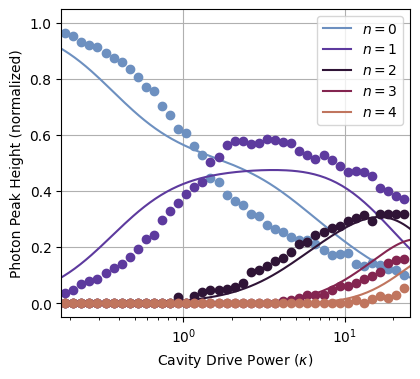

In [52]:
kappa = 0.1
colors = plt.cm.twilight(np.linspace(0.2, 0.8, 5))
fig, ax = plt.subplots(figsize=(4.5,4))
for i in range(5):
    y = data0[:, i]
    x = powers0/kappa
    plt.plot(x, y, '-o', color=colors[i], label=f'$n={i}$', markersize=0)
    y = hs0[:, i]
    x = power_to_kappa(xdata0)
    ax.plot(x, y, 'o', color=colors[i])
ax.set_xscale('log')
ax.set_xlabel(r'Cavity Drive Power ($\kappa$)')
ax.set_ylabel('Photon Peak Height (normalized)')
ax.grid()
ax.set_xlim(np.min(x)-0.01, np.max(x)+2)
ax.legend()
plt.show()

# N=1 Emitter

## Data

In [53]:
df = pd.read_csv(f'..\\experiment_data\\bus-Q4-pns_54.csv')
df1 = pd.read_csv(f'..\\experiment_data\\bus-Q4-pns_55.csv')
power = np.array(np.unique(df['power']))
freqs = np.array(np.unique(df['frequency']))
freqs1 = np.array(np.unique(df1['frequency']))
freqsc = np.concatenate([freqs, freqs1])
phase = np.flip(np.unwrap(np.array(df['phase']).reshape([len(power), len(freqs)])), axis=0)
phase1 = np.flip(np.unwrap(np.array(df1['phase']).reshape([len(power), len(freqs1)])), axis=0)
phasec = np.concatenate([phase, phase1], axis=1)
phasec = phasec.transpose()
phasec = phasec - np.mean(phasec, axis=0)

In [54]:
xdata1 = power
ydata1 = freqsc
zdata1 = phasec

In [55]:
chi = 35
kappa = 422
sz1 = (kappa/(2*chi))*(np.cos(zdata1) - 1)/(np.sin(zdata1))
sz1 = 0.5*(sz1-np.min(sz1))

In [56]:
fs1 = np.zeros([len(xdata1), 6])
hs1 = np.zeros([len(xdata1), 6])
alpha_est = np.zeros(len(xdata1))
for i in range(len(xdata1)):
    y = sz1[:, i] - np.min(sz1[:,i])
    y = scipy.signal.savgol_filter(y, 21, 3)
    pks = scipy.signal.find_peaks(y, height=0.075-np.min(sz1[:,i]), width=11, prominence=0.031)
    counter = 0
    for j in range(np.min([5, len(pks[0])])):
        if ydata1[pks[0][j]] > 5.348e9 and ydata1[pks[0][j]] < 5.360e9:
            fs1[i, counter] = ydata1[pks[0][j]]
            hs1[i, counter] = np.max([pks[1]['prominences'][j], 0])
            counter += 1
    hs1[i, :] = (hs1[i, :] - np.min(hs1[i, :]))/np.sum(hs1[i, :])
    alpha_est[i] = np.sum(hs1[i,:]*np.arange(6))

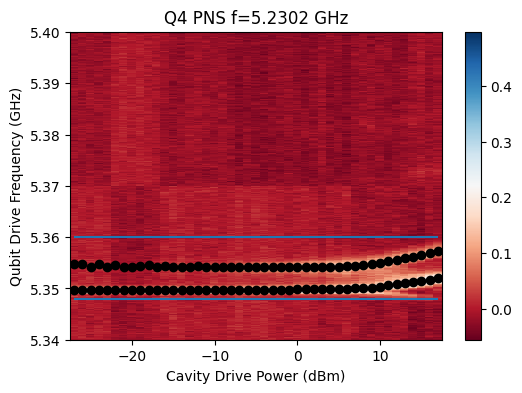

In [57]:
plt.figure(figsize=(6,4))
plt.pcolor(xdata1, ydata1/1e9, -zdata1, cmap='RdBu')
plt.colorbar()
plt.plot(xdata1, fs1/1e9, 'o', color='k')
plt.title(f'Q4 PNS f=5.2302 GHz')
plt.xlabel('Cavity Drive Power (dBm)')
plt.ylabel('Qubit Drive Frequency (GHz)')
plt.ylim([np.min(ydata1/1e9), None])
plt.hlines([5.348, 5.36], np.min(xdata1), np.max(xdata1))
plt.show()

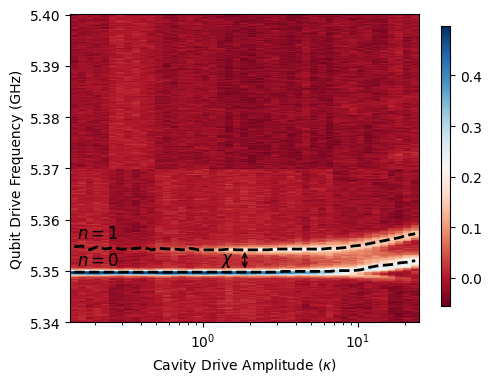

In [58]:
fig, ax = plt.subplots(figsize=(4.5,4))
test = ax.pcolor(power_to_kappa(xdata1), ydata1/1e9, -zdata1, cmap='RdBu')
cbaxes = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(test, ax=ax, cax=cbaxes)
for i in range(2):
    y = []
    powt = []
    for j in range(fs1.shape[0]):
        if fs1[j,i] > 0.1:
            y.append(fs1[j,i]/1e9)
            powt.append(xdata1[j])
    if i > 0:
        xs = power_to_kappa([-8., -5.])
        p1 = patches.FancyArrowPatch((xs[1], ylast[-15]), (xs[1], y[-15]), arrowstyle='<->', mutation_scale=8)
        ax.annotate(r"$\chi$", xy=(xs[0], 0.5*(ylast[-15] + y[-15])), va='center', fontsize=12)
        ax.add_patch(p1)
    ylast = y
    ax.plot(power_to_kappa(powt), y, '--', color='k', linewidth=2)
ax.set_xscale('log')
ax.set_xlabel(r'Cavity Drive Amplitude ($\kappa$)')
ax.set_ylabel('Qubit Drive Frequency (GHz)')
ax.set_ylim([np.min(ydata1/1e9), None])
ax.annotate("$n=0$", xy=(0.02, 0.23), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax.annotate("$n=1$", xy=(0.02, 0.32), xycoords='axes fraction', fontsize=12, ha='left', va='top')
plt.show()

In [16]:
power_to_kappa(power)[27], hs_exp[27,:]

NameError: name 'hs_exp' is not defined

## Compare to Simulation

In [59]:
df1 = pd.read_csv('N1-blockade-sim-test.csv')

In [60]:
powers1 = np.unique(np.array(df1['power']))
vac1 = np.array(df1['vac'])
sp1 = np.array(df1['sp'])
sm1 = np.array(df1['sm'])

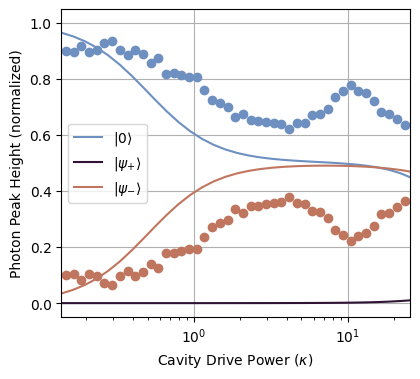

In [61]:
kappa = 0.1
colors = plt.cm.twilight(np.linspace(0.2, 0.8, 3))
fig, ax = plt.subplots(figsize=(4.5,4))
x = powers1/kappa
ax.plot(x, vac1, '-', color=colors[0], label=r'$|0\rangle$')
ax.plot(x, sp1, '-', color=colors[1], label=r'$|\psi_{+}\rangle$')
ax.plot(x, sm1, '-', color=colors[2], label=r'$|\psi_{-}\rangle$')
# x = 4*10**(power/20)
x = power_to_kappa(xdata1)
y = hs1[:, 0]
plt.plot(x, y, 'o', color=colors[0])
y = hs1[:, 1]
ax.plot(x, y, 'o', color=colors[2])
ax.set_xlabel(r'Cavity Drive Power ($\kappa$)')
ax.set_ylabel('Photon Peak Height (normalized)')
ax.grid()
ax.legend(ncols=1)
ax.set_xlim(np.min(x)-0.01, np.max(x)+2)
ax.set_xscale('log')
plt.show()

# N=2 Emitter

## Data

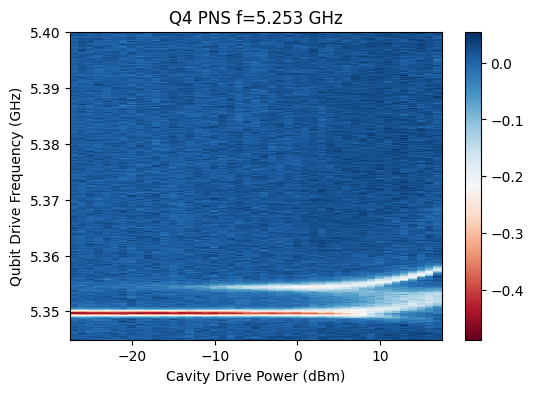

In [62]:
df = pd.read_csv(f'..\\experiment_data\\bus-Q4-pns_59.csv')
power = np.array(np.unique(df['power']))
freqs = np.array(np.unique(df['frequency']))
phase = np.flip(np.unwrap(np.array(df['phase']).reshape([len(power), len(freqs)])), axis=0)
phase = phase.transpose()
phase = phase - np.mean(phase, axis=0)
plt.figure(figsize=(6,4))
plt.pcolor(power, freqs/1e9, phase, cmap='RdBu')
plt.colorbar()
plt.title(f'Q4 PNS f=5.253 GHz')
plt.xlabel('Cavity Drive Power (dBm)')
plt.ylabel('Qubit Drive Frequency (GHz)')
plt.show()

In [63]:
xdata2 = power
ydata2 = freqs
zdata2 = phase

In [64]:
chi = 35
kappa = 422
sz2 = (kappa/(2*chi))*(np.cos(zdata2) - 1)/(np.sin(zdata2))
sz2 = 0.5*(sz2-np.min(sz2))

In [65]:
fs2 = np.zeros([len(xdata2), 6])
hs2 = np.zeros([len(xdata2), 6])
alpha_est = np.zeros(len(xdata2))
for i in range(len(xdata2)):
    y = sz2[:, i] - np.min(sz2[:,i])
    y = scipy.signal.savgol_filter(y, 11, 3)
    pks, props = scipy.signal.find_peaks(y, height=0.059, width=6, distance=24, prominence=0.025)
    # print(props['left_bases'])
    counter = 0
    proms = props['prominences']
    if props['left_bases'][0] == props['left_bases'][1]:
        proms[0], proms[1] = proms[1], proms[0]
    for j in range(np.min([5, len(pks)])):
        if ydata2[pks[j]] > 5.348e9 and ydata2[pks[j]] < 5.360e9:
            fs2[i, counter] = ydata2[pks[j]]
            hs2[i, counter] = np.max([proms[j], 0])
            counter += 1
    hs2[i, :] = (hs2[i, :])/np.sum(hs2[i, :])
    alpha_est[i] = np.sum(hs2[i,:]*np.arange(6))

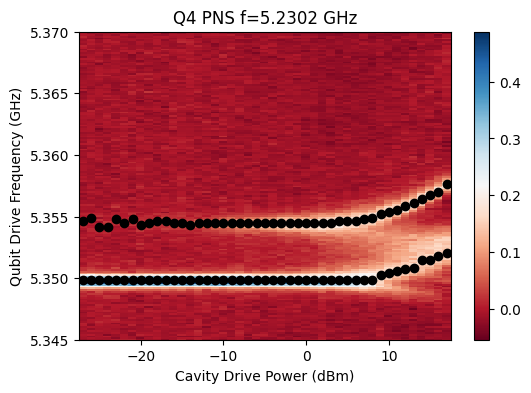

In [66]:
plt.figure(figsize=(6,4))
plt.pcolor(xdata2, ydata2/1e9, -zdata2, cmap='RdBu')
plt.colorbar()
plt.plot(xdata2, fs2/1e9, 'o', color='k')
plt.title(f'Q4 PNS f=5.2302 GHz')
plt.xlabel('Cavity Drive Power (dBm)')
plt.ylabel('Qubit Drive Frequency (GHz)')
plt.ylim([np.min(ydata2/1e9), 5.37])
# plt.hlines([5.348, 5.36], np.min(power), np.max(power))
plt.show()

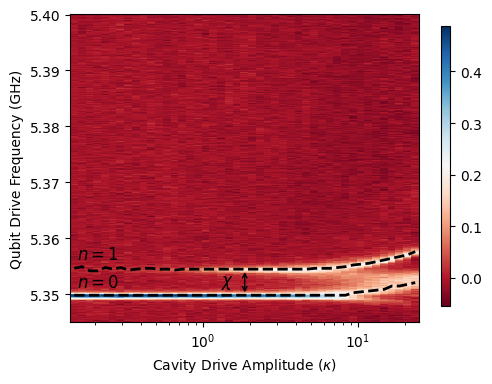

In [67]:
fig, ax = plt.subplots(figsize=(4.5,4))
test = ax.pcolor(power_to_kappa(xdata2), ydata2/1e9, -zdata2, cmap='RdBu')
cbaxes = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(test, ax=ax, cax=cbaxes)
for i in range(2):
    y = []
    powt = []
    for j in range(fs2.shape[0]):
        if fs2[j,i] > 0.1:
            y.append(fs2[j,i]/1e9)
            powt.append(xdata2[j])
    if i > 0:
        xs = power_to_kappa([-8., -5.])
        p1 = patches.FancyArrowPatch((xs[1], ylast[-15]), (xs[1], y[-15]), arrowstyle='<->', mutation_scale=8)
        ax.annotate(r"$\chi$", xy=(xs[0], 0.5*(ylast[-15] + y[-15])), va='center', fontsize=12)
        ax.add_patch(p1)
    ylast = y
    ax.plot(power_to_kappa(powt), y, '--', color='k', linewidth=2)
ax.set_xscale('log')
ax.set_xlabel(r'Cavity Drive Amplitude ($\kappa$)')
ax.set_ylabel('Qubit Drive Frequency (GHz)')
ax.set_ylim([np.min(ydata2/1e9), None])
ax.annotate("$n=0$", xy=(0.02, 0.16), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax.annotate("$n=1$", xy=(0.02, 0.25), xycoords='axes fraction', fontsize=12, ha='left', va='top')
plt.show()

In [68]:
power_to_kappa(power)[27]

3.3043188462294193

In [24]:
hs_exp[27]

NameError: name 'hs_exp' is not defined

## Compare to Simulation

In [69]:
df2 = pd.read_csv('N2-blockade-sim-test.csv')

In [70]:
powers2 = np.unique(np.array(df2['power']))
vac2 = np.array(df2['vac'])
sp2 = np.array(df2['sp'])
sm2 = np.array(df2['sm'])

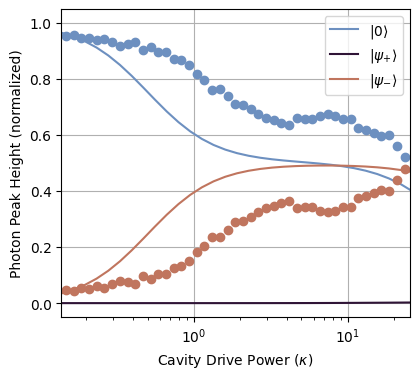

In [71]:
kappa = 0.1
colors = plt.cm.twilight(np.linspace(0.2, 0.8, 3))
fig, ax = plt.subplots(figsize=(4.5,4))
x = powers2/kappa
ax.plot(x, vac2, '-', color=colors[0], label=r'$|0\rangle$')
ax.plot(x, sp2, '-', color=colors[1], label=r'$|\psi_{+}\rangle$')
ax.plot(x, sm2, '-', color=colors[2], label=r'$|\psi_{-}\rangle$')
x = power_to_kappa(xdata2)
y = hs2[:, 0]
plt.plot(x, y, 'o', color=colors[0])
y = hs2[:, 1]
ax.plot(x, y, 'o', color=colors[2])
ax.set_xlabel(r'Cavity Drive Power ($\kappa$)')
ax.set_ylabel('Photon Peak Height (normalized)')
ax.grid()
ax.legend(ncols=1)
ax.set_xlim(np.min(x)-0.01, np.max(x)+2)
ax.set_xscale('log')
plt.show()

# N=3 Emitter

## Data

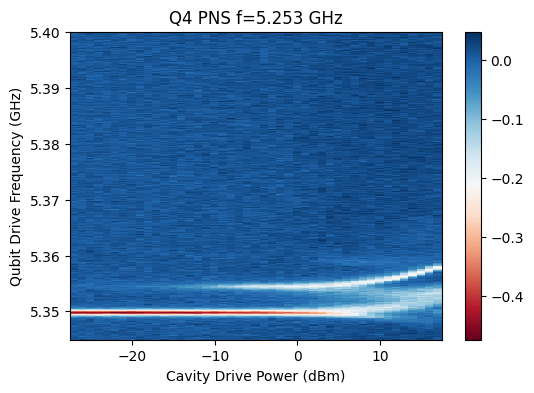

In [72]:
df = pd.read_csv(f'..\\experiment_data\\bus-Q4-pns_64.csv')
power = np.array(np.unique(df['power']))
freqs = np.array(np.unique(df['frequency']))
phase = np.flip(np.unwrap(np.array(df['phase']).reshape([len(power), len(freqs)])), axis=0)
phase = phase.transpose()
phase = phase - np.mean(phase, axis=0)
plt.figure(figsize=(6,4))
plt.pcolor(power, freqs/1e9, phase, cmap='RdBu')
plt.colorbar()
plt.title(f'Q4 PNS f=5.253 GHz')
plt.xlabel('Cavity Drive Power (dBm)')
plt.ylabel('Qubit Drive Frequency (GHz)')
plt.show()

In [73]:
xdata3 = power
ydata3 = freqs
zdata3 = phase

In [74]:
chi = 35
kappa = 422
sz3 = (kappa/(2*chi))*(np.cos(zdata3) - 1)/(np.sin(zdata3))
sz3 = 0.5*(sz3-np.min(sz3))

In [75]:
fs3 = np.zeros([len(xdata3), 6])
hs3 = np.zeros([len(xdata3), 6])
alpha_est = np.zeros(len(xdata3))
for i in range(len(xdata3)):
    y = sz3[:, i] - np.min(sz3[:,i])
    y = scipy.signal.savgol_filter(y, 11, 3)
    pks, props = scipy.signal.find_peaks(y, height=0.052, width=6, distance=28, prominence=0.015)
    counter = 0
    proms = props['prominences']
    if props['left_bases'][0] == props['left_bases'][1]:
        proms[0], proms[1] = proms[1], proms[0]
    for j in range(2):
        if ydata3[pks[j]] > 5.348e9 and ydata3[pks[j]] < 5.360e9:
            fs3[i, counter] = ydata3[pks[j]]
            hs3[i, counter] = np.max(proms[j], 0)
            counter += 1
    hs3[i, :] = (hs3[i, :])/np.sum(hs3[i, :])
    alpha_est[i] = np.sum(hs3[i,:]*np.arange(6))

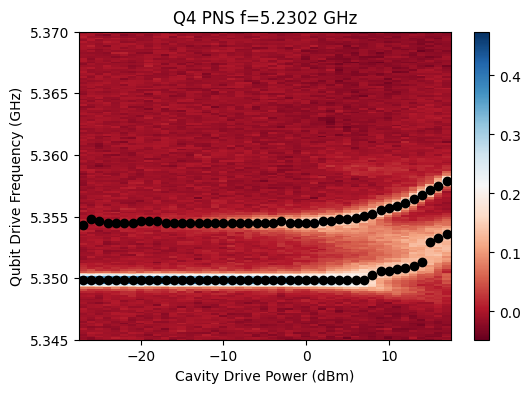

In [76]:
plt.figure(figsize=(6,4))
plt.pcolor(xdata3, ydata3/1e9, -zdata3, cmap='RdBu')
plt.colorbar()
plt.plot(xdata3, fs3/1e9, 'o', color='k')
plt.title(f'Q4 PNS f=5.2302 GHz')
plt.xlabel('Cavity Drive Power (dBm)')
plt.ylabel('Qubit Drive Frequency (GHz)')
plt.ylim([np.min(ydata3/1e9), 5.37])
# plt.hlines([5.348, 5.36], np.min(power), np.max(power))
plt.show()

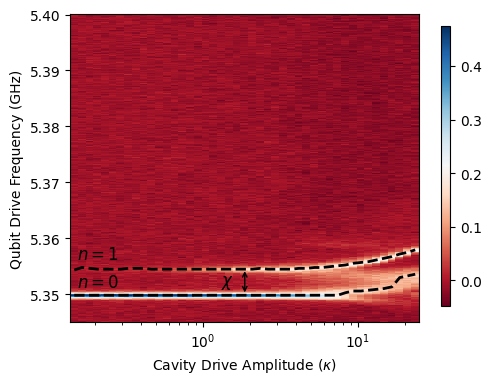

In [77]:
fig, ax = plt.subplots(figsize=(4.5,4))
test = ax.pcolor(power_to_kappa(xdata3), ydata3/1e9, -zdata3, cmap='RdBu')
cbaxes = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(test, ax=ax, cax=cbaxes)
for i in range(2):
    y = []
    powt = []
    for j in range(fs3.shape[0]):
        if fs3[j,i] > 0.1:
            y.append(fs3[j,i]/1e9)
            powt.append(xdata3[j])
    if i > 0:
        xs = power_to_kappa([-8., -5.])
        p1 = patches.FancyArrowPatch((xs[1], ylast[-15]), (xs[1], y[-15]), arrowstyle='<->', mutation_scale=8)
        ax.annotate("$\chi$", xy=(xs[0], 0.5*(ylast[-15] + y[-15])), va='center', fontsize=12)
        ax.add_patch(p1)
    ylast = y
    ax.plot(power_to_kappa(powt), y, '--', color='k', linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Cavity Drive Amplitude ($\kappa$)')
ax.set_ylabel('Qubit Drive Frequency (GHz)')
ax.set_ylim([np.min(ydata3/1e9), None])
ax.annotate("$n=0$", xy=(0.02, 0.16), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax.annotate("$n=1$", xy=(0.02, 0.25), xycoords='axes fraction', fontsize=12, ha='left', va='top')
plt.show()

## Compare to Simulation

In [78]:
df3 = pd.read_csv('N3-blockade-sim-test-d5.csv')

In [79]:
powers3 = np.unique(np.array(df3['power']))
vac3 = np.array(df3['vac'])
sp3 = np.array(df3['sp'])
sm3 = np.array(df3['sm'])

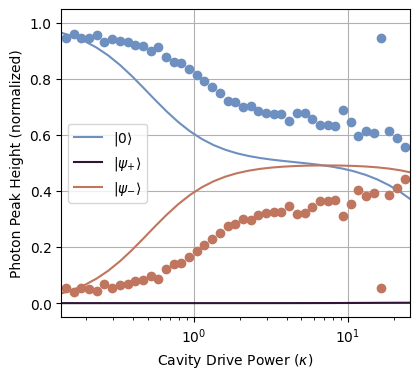

In [80]:
kappa = 0.1
colors = plt.cm.twilight(np.linspace(0.2, 0.8, 3))
fig, ax = plt.subplots(figsize=(4.5,4))
x = powers3/kappa
ax.plot(x, vac3, '-', color=colors[0], label=r'$|0\rangle$')
ax.plot(x, sp3, '-', color=colors[1], label=r'$|\psi_{+}\rangle$')
ax.plot(x, sm3, '-', color=colors[2], label=r'$|\psi_{-}\rangle$')
x = power_to_kappa(xdata3)
y = hs3[:, 0]
plt.plot(x, y, 'o', color=colors[0])
y = hs3[:, 1]
ax.plot(x, y, 'o', color=colors[2])
ax.set_xlabel(r'Cavity Drive Power ($\kappa$)')
ax.set_ylabel('Photon Peak Height (normalized)')
ax.grid()
ax.legend(ncols=1)
ax.set_xlim(np.min(x)-0.01, np.max(x)+2)
ax.set_xscale('log')
plt.show()

In [81]:
power_to_kappa(power)[27]

3.3043188462294193

In [40]:
hs_exp[27,:]

NameError: name 'hs_exp' is not defined

# Compiled Fig. 2

Text(0, 0.5, 'Peak Height (normalized)')

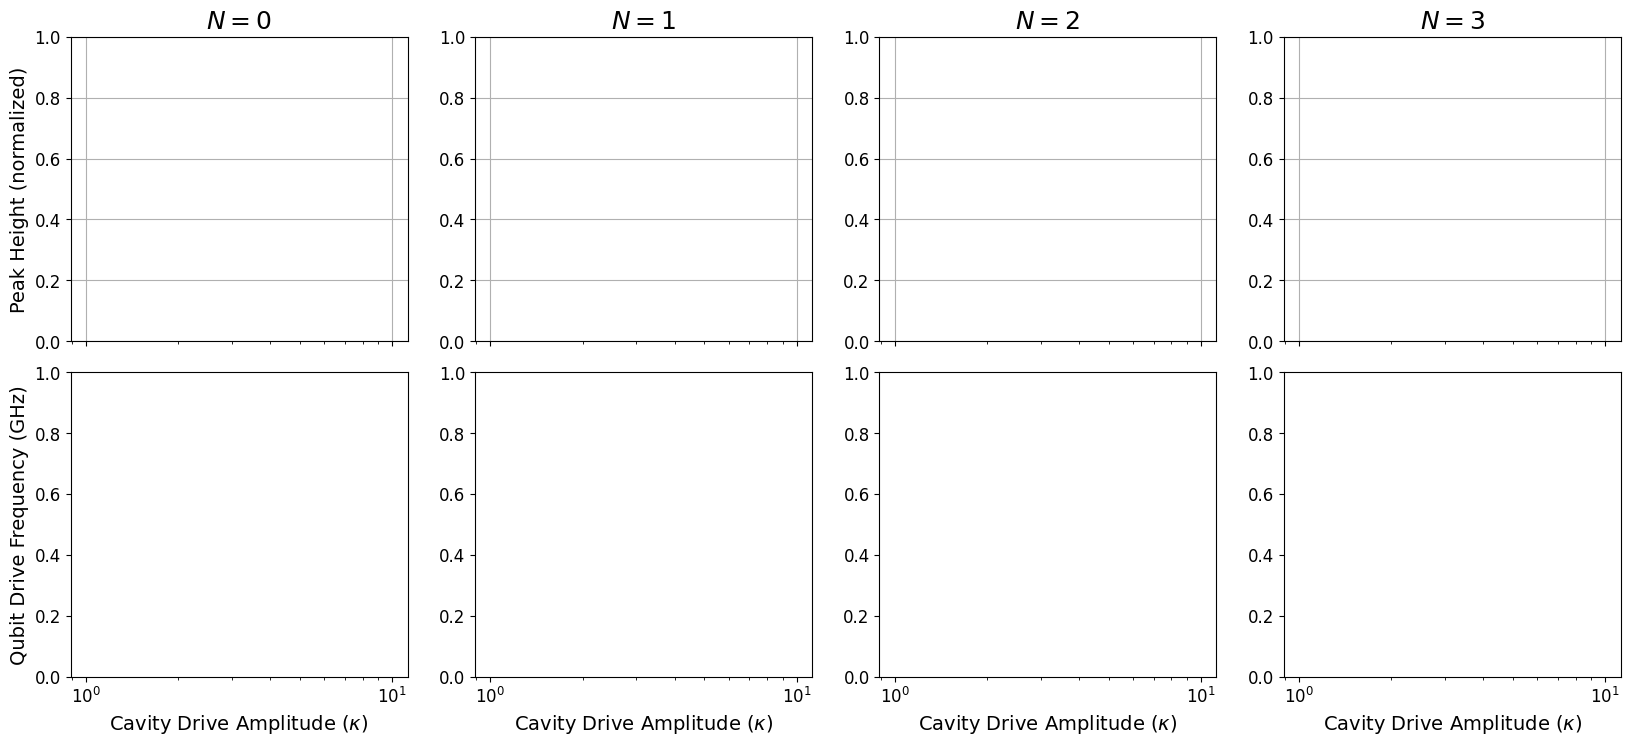

In [93]:
fig, ax = plt.subplots(2, 4, figsize=(20,8), sharex='col')
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.1)
letters = ['a', 'b', 'c', 'd']
for N in range(4):
    ax[0, N].set_title(f'({letters[N]}) $N={N}$', fontsize=18)
    ax[0, N].set_title(f'$N={N}$', fontsize=18)
    ax[0, N].grid()
    ax[1, N].set_xlabel('Cavity Drive Amplitude ($\kappa$)', fontsize=14)
    ax[1, N].set_xscale('log')
    ax[1, N].tick_params(labelsize=12)
    ax[0, N].tick_params(labelsize=12)
ax[1,0].set_ylabel('Qubit Drive Frequency (GHz)', fontsize=14)
ax[0,0].set_ylabel('Peak Height (normalized)', fontsize=14)

In [94]:
axs = ax[1,0]
pc0 = axs.pcolor(power_to_kappa(xdata0), ydata0/1e9, -zdata0, cmap='RdBu', rasterized=True)
# cbaxes = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# cb = fig.colorbar(pc0, ax=ax, cax=cbaxes)
for i in range(fs0.shape[1]-1):
    y = []
    powt = []
    for j in range(fs0.shape[0]):
        if fs0[j,i] > 0.1:
            y.append(fs0[j,i]/1e9)
            powt.append(xdata0[j])
    if i > 0:
        xs = power_to_kappa([13.,16.])
        p1 = patches.FancyArrowPatch((xs[1], ylast[-2]), (xs[1], y[-2]), arrowstyle='<->', mutation_scale=8)
        axs.annotate("$2\chi$", xy=(xs[0], 0.5*(ylast[-2] + y[-2])), va='center', fontsize=12)
        axs.add_patch(p1)
    ylast = y
    axs.plot(power_to_kappa(powt), y, '-', color='k', linewidth=2)
axs.set_ylim([np.min(ydata0/1e9), None])
axs.annotate("$n=0$", xy=(0.02, 0.2), xycoords='axes fraction', fontsize=16, ha='left', va='top')
axs.annotate("$n=1$", xy=(0.02, 0.35), xycoords='axes fraction', fontsize=16, ha='left', va='top')
axs.annotate("$n=2$", xy=(0.4, 0.48), xycoords='axes fraction', fontsize=16, ha='left', va='top')
axs.annotate("$n=3$", xy=(0.69, 0.66), xycoords='axes fraction', fontsize=16, ha='left', va='top')
axs.annotate("$n=4$", xy=(0.80, 0.84), xycoords='axes fraction', fontsize=16, ha='left', va='top')
axs.annotate(text='', xy=(1,1), xytext=(0,0), arrowprops=dict(arrowstyle='<->'))

Text(0, 0, '')

In [95]:
axs = ax[0,0]
kappa = 0.1
colors = plt.cm.twilight(np.linspace(0.2, 0.8, 5))
for i in range(5):
    y = data0[:, i]
    x = powers0/kappa
    axs.plot(x, y, '-o', color=colors[i], label=f'$n={i}$', markersize=0)
    y = hs0[:, i]
    x = power_to_kappa(xdata0)
    axs.plot(x, y, 'o', color=colors[i])
axs.set_xlim(np.min(x)-0.01, np.max(x)+1)
axs.legend(fontsize=12, ncols=2)

In [96]:
axs = ax[1,1]
pc0 = axs.pcolor(power_to_kappa(xdata1), ydata1/1e9, -zdata1, cmap='RdBu', rasterized=True)
# cbaxes = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# cb = fig.colorbar(pc0, ax=ax, cax=cbaxes)
for i in range(2):
    y = []
    powt = []
    for j in range(fs1.shape[0]):
        if fs1[j,i] > 0.1:
            y.append(fs1[j,i]/1e9)
            powt.append(xdata1[j])
    if i > 0:
        xs = power_to_kappa([-8., -5.])
        p1 = patches.FancyArrowPatch((xs[1], ylast[-15]), (xs[1], y[-15]), arrowstyle='<->', mutation_scale=8)
        axs.annotate(r"$\chi$", xy=(xs[0], 0.5*(ylast[-15] + y[-15])), va='center', fontsize=12)
        axs.add_patch(p1)
    ylast = y
    axs.plot(power_to_kappa(powt), y, '-', color='k', linewidth=2)
axs.set_ylim([np.min(ydata3/1e9), None])
axs.annotate("$n=0$", xy=(0.02, 0.16), xycoords='axes fraction', fontsize=12, ha='left', va='top')
axs.annotate("$n=1$", xy=(0.02, 0.25), xycoords='axes fraction', fontsize=12, ha='left', va='top')
axs.annotate(text='', xy=(1,1), xytext=(0,0), arrowprops=dict(arrowstyle='<->'))

Text(0, 0, '')

In [97]:
axs = ax[0,1]
kappa = 0.1
colors = plt.cm.twilight(np.linspace(0.2, 0.8, 3))
x = powers1/kappa
axs.plot(x, vac1, '-', color=colors[0], label=r'$|0\rangle$')
axs.plot(x, sp1, '-', color=colors[1], label=r'$|\psi_{+}\rangle$')
axs.plot(x, sm1, '-', color=colors[2], label=r'$|\psi_{-}\rangle$')
x = power_to_kappa(xdata1)
y = hs1[:, 0]
axs.plot(x, y, 'o', color=colors[0])
y = hs1[:, 1]
axs.plot(x, y, 'o', color=colors[2])
axs.legend(ncols=1, fontsize=12)
axs.set_xlim(np.min(x)-0.01, np.max(x)+1)

(0.13759850118458838, 24.392785974491748)

In [98]:
axs = ax[1,2]
pc0 = axs.pcolor(power_to_kappa(xdata2), ydata2/1e9, -zdata2, cmap='RdBu', rasterized=True)
# cbaxes = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# cb = fig.colorbar(pc0, ax=ax, cax=cbaxes)
for i in range(2):
    y = []
    powt = []
    for j in range(fs2.shape[0]):
        if fs2[j,i] > 0.1:
            y.append(fs2[j,i]/1e9)
            powt.append(xdata2[j])
    if i > 0:
        xs = power_to_kappa([-8., -5.])
        p1 = patches.FancyArrowPatch((xs[1], ylast[-15]), (xs[1], y[-15]), arrowstyle='<->', mutation_scale=8)
        axs.annotate(r"$\chi$", xy=(xs[0], 0.5*(ylast[-15] + y[-15])), va='center', fontsize=12)
        axs.add_patch(p1)
    ylast = y
    axs.plot(power_to_kappa(powt), y, '-', color='k', linewidth=2)
axs.set_ylim([np.min(ydata3/1e9), None])
axs.annotate("$n=0$", xy=(0.02, 0.16), xycoords='axes fraction', fontsize=12, ha='left', va='top')
axs.annotate("$n=1$", xy=(0.02, 0.25), xycoords='axes fraction', fontsize=12, ha='left', va='top')
axs.annotate(text='', xy=(1,1), xytext=(0,0), arrowprops=dict(arrowstyle='<->'))

Text(0, 0, '')

In [99]:
axs = ax[0,2]
kappa = 0.1
colors = plt.cm.twilight(np.linspace(0.2, 0.8, 3))
x = powers2/kappa
axs.plot(x, vac2, '-', color=colors[0], label=r'$|0\rangle$')
axs.plot(x, sp2, '-', color=colors[1], label=r'$|\psi_{+}\rangle$')
axs.plot(x, sm2, '-', color=colors[2], label=r'$|\psi_{-}\rangle$')
x = power_to_kappa(xdata2)
y = hs2[:, 0]
axs.plot(x, y, 'o', color=colors[0])
y = hs2[:, 1]
axs.plot(x, y, 'o', color=colors[2])
# axs.legend(ncols=1)
axs.set_xlim(np.min(x)-0.01, np.max(x)+1)

(0.13759850118458838, 24.392785974491748)

In [100]:
axs = ax[1,3]
pc0 = axs.pcolor(power_to_kappa(xdata3), ydata3/1e9, -zdata3, cmap='RdBu', rasterized=True)
# cbaxes = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# cb = fig.colorbar(pc0, ax=ax, cax=cbaxes)
for i in range(2):
    y = []
    powt = []
    for j in range(fs3.shape[0]):
        if fs3[j,i] > 0.1:
            y.append(fs3[j,i]/1e9)
            powt.append(xdata3[j])
    if i > 0:
        xs = power_to_kappa([-8., -5.])
        p1 = patches.FancyArrowPatch((xs[1], ylast[-15]), (xs[1], y[-15]), arrowstyle='<->', mutation_scale=8)
        axs.annotate(r"$\chi$", xy=(xs[0], 0.5*(ylast[-15] + y[-15])), va='center', fontsize=12)
        axs.add_patch(p1)
    ylast = y
    axs.plot(power_to_kappa(powt), y, '-', color='k', linewidth=2)
axs.set_ylim([np.min(ydata3/1e9), None])
axs.annotate("$n=0$", xy=(0.02, 0.16), xycoords='axes fraction', fontsize=12, ha='left', va='top')
axs.annotate("$n=1$", xy=(0.02, 0.25), xycoords='axes fraction', fontsize=12, ha='left', va='top')
axs.annotate(text='', xy=(1,1), xytext=(0,0), arrowprops=dict(arrowstyle='<->'))

Text(0, 0, '')

In [101]:
axs = ax[0,3]
kappa = 0.1
colors = plt.cm.twilight(np.linspace(0.2, 0.8, 3))
x = powers3/kappa
axs.plot(x, vac3, '-', color=colors[0], label=r'$|0\rangle$')
axs.plot(x, sp3, '-', color=colors[1], label=r'$|\psi_{+}\rangle$')
axs.plot(x, sm3, '-', color=colors[2], label=r'$|\psi_{-}\rangle$')
x = power_to_kappa(xdata3)
y = hs3[:, 0]
axs.plot(x, y, 'o', color=colors[0])
y = hs3[:, 1]
axs.plot(x, y, 'o', color=colors[2])
# axs.legend(ncols=1)
axs.set_xlim(np.min(x)-0.01, np.max(x)+1)

(0.13759850118458838, 24.392785974491748)

In [102]:
# fig.tight_layout()
# fig.savefig('fig3.pdf', bbox_inches='tight')

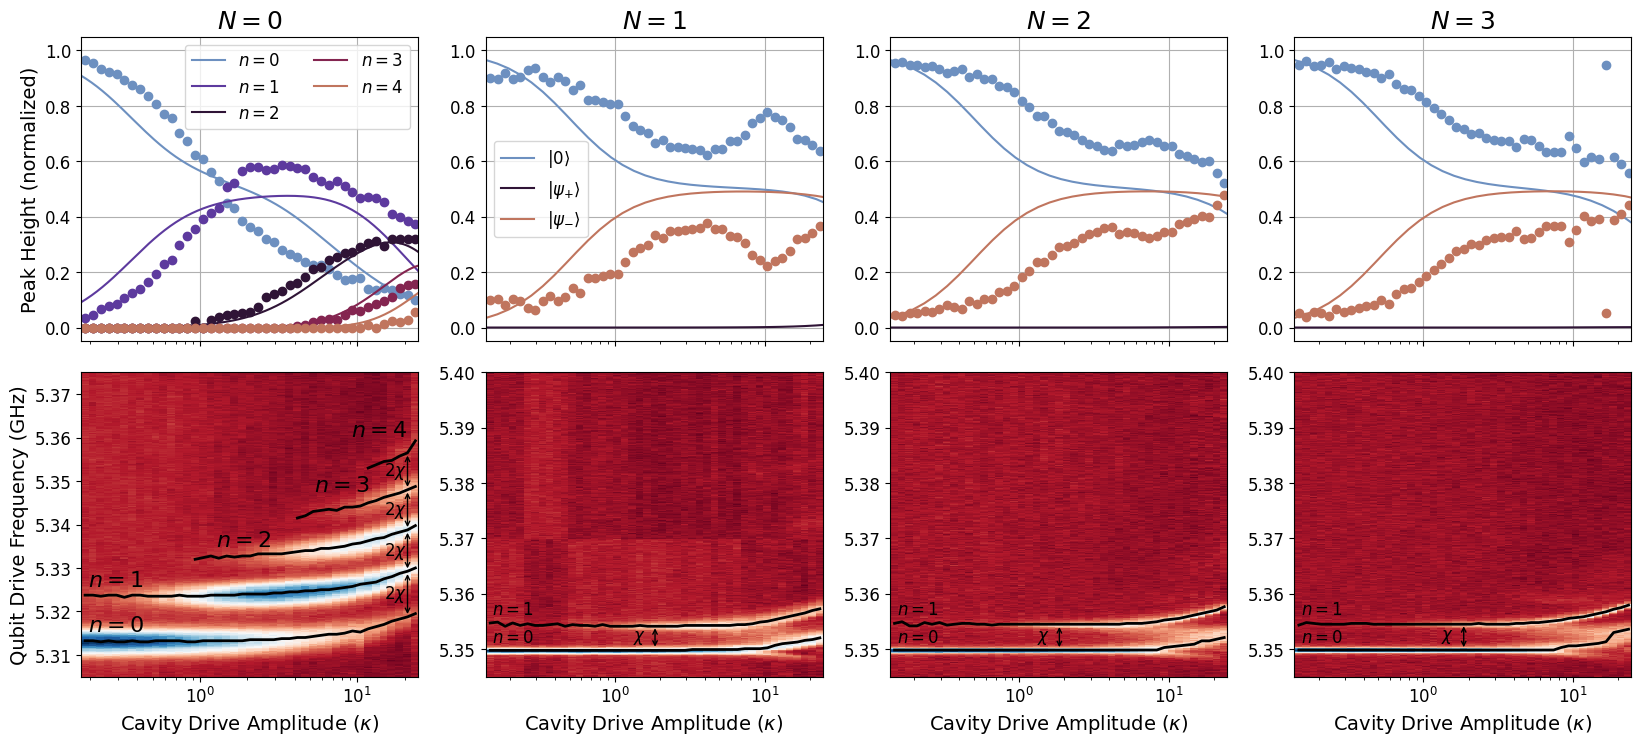

In [103]:
fig

In [117]:
power_to_kappa(xdata1[-1])

23.392785974491748

# Peak Comparison vs. N

In [109]:
pkc0 = hs0[25,:3]
pkc1 = hs1[27,:3]
pkc2 = hs2[27,:3]
pkc3 = hs3[27,:3]
pkd0 = hs0[7,:3]
pkd1 = hs1[9,:3]
pkd2 = hs2[9,:3]
pkd3 = hs3[9,:3]

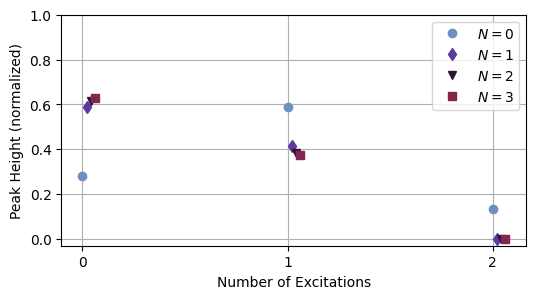

In [110]:
fig, ax = plt.subplots(figsize=(6,3))
colors = plt.cm.twilight(np.linspace(0.2, 0.8, 5))
ax.plot(np.arange(0, 3), pkc0, 'o', label='$N=0$', color=colors[0])
ax.plot(np.arange(0, 3)+0.02, pkc1, 'd', label='$N=1$', color=colors[1])
ax.plot(np.arange(0, 3)+0.04, pkc2, 'v', label='$N=2$', color=colors[2])
ax.plot(np.arange(0, 3)+0.06, pkc3, 's', label='$N=3$', color=colors[3])
ax.set_xticks([0, 1, 2])
ax.legend()
ax.set_yticks(np.linspace(0, 1, 6))
ax.grid()
ax.set_ylabel('Peak Height (normalized)')
ax.set_xlabel('Number of Excitations')
plt.show()

In [112]:
power_to_kappa([xdata0[7], xdata1[9]])

array([0.4159891, 0.4159891])

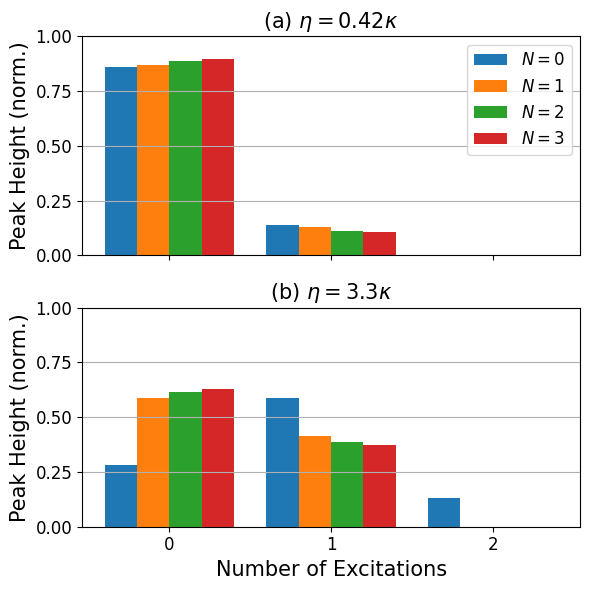

In [128]:
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)
colors = plt.cm.twilight(np.linspace(0.2, 0.8, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
width = 0.2
x = np.arange(0,3)
ax[1].bar(x-1.5*width, pkc0, width=width, label='$N=0$', color=colors[0])
ax[1].bar(x-0.5*width, pkc1, width=width, label='$N=1$', color=colors[1])
ax[1].bar(x+0.5*width, pkc2, width=width, label='$N=2$', color=colors[2])
ax[1].bar(x+1.5*width, pkc3, width=width, label='$N=3$', color=colors[3])
ax[0].bar(x-1.5*width, pkd0, width=width, label='$N=0$', color=colors[0])
ax[0].bar(x-0.5*width, pkd1, width=width, label='$N=1$', color=colors[1])
ax[0].bar(x+0.5*width, pkd2, width=width, label='$N=2$', color=colors[2])
ax[0].bar(x+1.5*width, pkd3, width=width, label='$N=3$', color=colors[3])
ax[0].legend(fontsize=12)
ax[0].yaxis.grid()
ax[1].yaxis.grid()
ax[0].set_title('(a) $\eta=0.42\kappa$', fontsize=15)
ax[1].set_title('(b) $\eta=3.3\kappa$', fontsize=15)
ax[1].set_yticks(np.linspace(0, 1, 5))
ax[0].set_yticks(np.linspace(0, 1, 5))
ax[0].set_xticks([0, 1, 2])
ax[0].set_ylabel('Peak Height (norm.)', fontsize=15)
ax[1].set_ylabel('Peak Height (norm.)', fontsize=15)
ax[1].set_xlabel('Number of Excitations', fontsize=15)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].tick_params(axis='both', labelsize=12)
fig.tight_layout()
fig.savefig('fig4.pdf')
plt.show()

# Frequency Dependence and Polariton Splitting

## Qubit Couplings

In [104]:
files = ['polariton-splitting-Q4',
         'polariton-splitting-Q5',
         'polariton-splitting-Q6',
         'polariton-splitting-Q7',
        ]

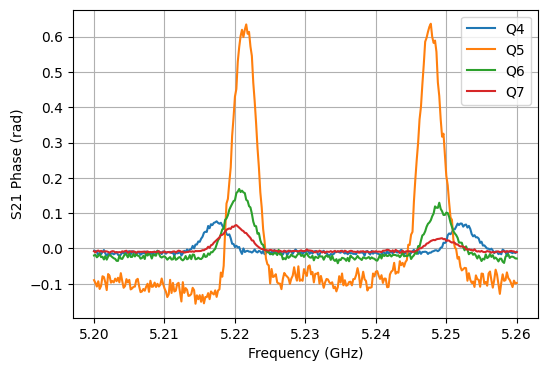

In [105]:
polaritons = []
plt.figure(figsize=(6,4))
for f in files:
    df = pd.read_csv('..\\..\\' + f + '.csv')
    y = df['phase'] - np.mean(df['phase'])
    plt.plot(df['frequency']/1e9, -y, label=f[20:])
    peaks = scipy.signal.find_peaks(-y, height=0.01, distance=30)
    pfreqs = [df['frequency'][peak] for peak in peaks[0]]
    polaritons.append(pfreqs)
plt.grid()
plt.xlabel('Frequency (GHz)')
plt.ylabel('S21 Phase (rad)')
plt.legend()
plt.show()
polaritons = np.array(polaritons)

In [106]:
np.mean((polaritons[:,1] - polaritons[:,0])[1:])/2/1e6

13.966666666666667

In [107]:
exactgs = np.sqrt(
    np.array([
        np.sum((polaritons[:,1] - polaritons[:,0])[1]**2),
        np.sum((polaritons[:,1] - polaritons[:,0])[1:3]**2),
        np.sum((polaritons[:,1] - polaritons[:,0])[1:4]**2)
    ])
)

In [108]:
exactgs

array([26200000.        , 38639358.17272332, 48431807.73004452])

## Data

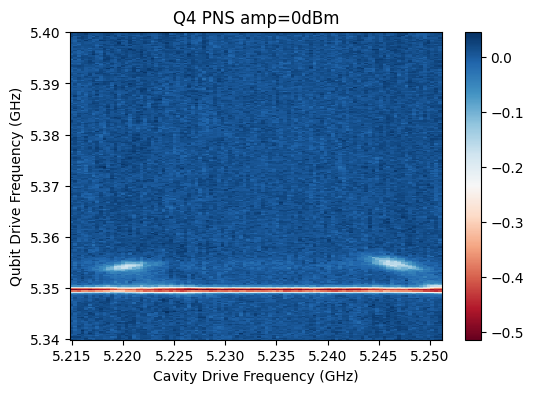

In [109]:
df = pd.read_csv(f'..\\experiment_data\\bus-Q4-pns_53.csv')
bfreqs = np.array(np.unique(df['frequency']))
qfreqs = np.array(np.unique(df['frequency.1']))
phase = np.unwrap(np.array(df['phase']).reshape([len(bfreqs), len(qfreqs)]))
phase = phase.transpose()
phase = phase - np.mean(phase, axis=0)
plt.figure(figsize=(6,4))
plt.pcolor(bfreqs/1e9, qfreqs/1e9, phase, cmap='RdBu')
plt.colorbar()
plt.title(f'Q4 PNS amp=0dBm')
plt.xlabel('Cavity Drive Frequency (GHz)')
plt.ylabel('Qubit Drive Frequency (GHz)')
plt.show()

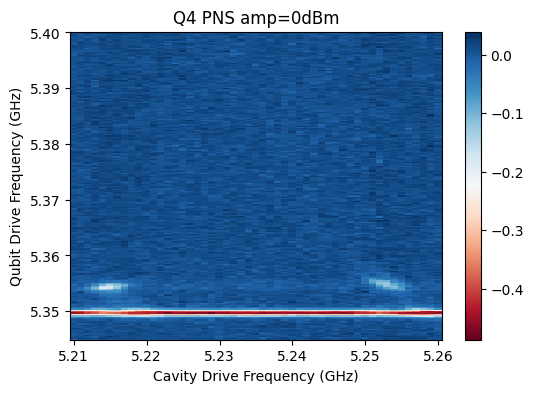

In [110]:
df = pd.read_csv(f'..\\experiment_data\\bus-Q4-pns_58.csv')
bfreqs = np.array(np.unique(df['frequency']))
qfreqs = np.array(np.unique(df['frequency.1']))
phase = np.unwrap(np.array(df['phase']).reshape([len(bfreqs), len(qfreqs)]))
phase = phase.transpose()
phase = phase - np.mean(phase, axis=0)
plt.figure(figsize=(6,4))
plt.pcolor(bfreqs/1e9, qfreqs/1e9, phase, cmap='RdBu')
plt.colorbar()
plt.title(f'Q4 PNS amp=0dBm')
plt.xlabel('Cavity Drive Frequency (GHz)')
plt.ylabel('Qubit Drive Frequency (GHz)')
plt.show()

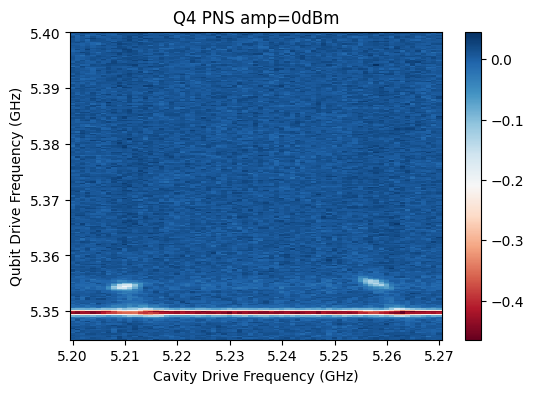

In [111]:
df = pd.read_csv(f'..\\experiment_data\\bus-Q4-pns_65.csv')
bfreqs = np.array(np.unique(df['frequency']))
qfreqs = np.array(np.unique(df['frequency.1']))
phase = np.unwrap(np.array(df['phase']).reshape([len(bfreqs), len(qfreqs)]))
phase = phase.transpose()
phase = phase - np.mean(phase, axis=0)
plt.figure(figsize=(6,4))
plt.pcolor(bfreqs/1e9, qfreqs/1e9, phase, cmap='RdBu')
plt.colorbar()
plt.title(f'Q4 PNS amp=0dBm')
plt.xlabel('Cavity Drive Frequency (GHz)')
plt.ylabel('Qubit Drive Frequency (GHz)')
plt.show()

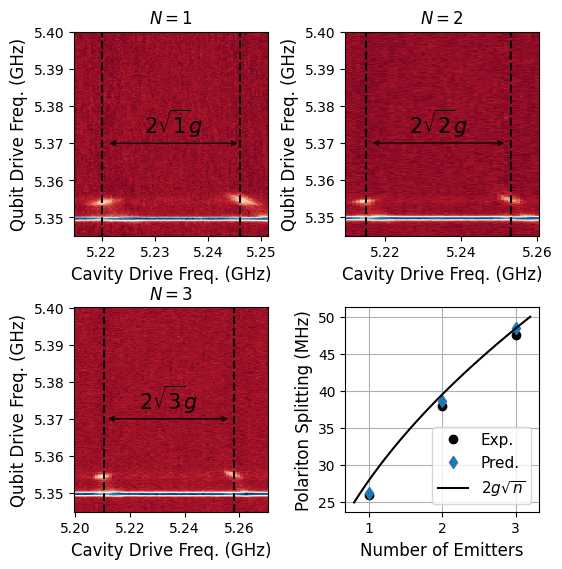

In [115]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.35)
idxs = np.array([53, 58, 65])
for i, idx in enumerate(idxs):
    df = pd.read_csv(f'..\\experiment_data\\bus-Q4-pns_{idx}.csv')
    bfreqs = np.array(np.unique(df['frequency']))
    qfreqs = np.array(np.unique(df['frequency.1']))
    phase = np.unwrap(np.array(df['phase']).reshape([len(bfreqs), len(qfreqs)]))
    phase = phase.transpose()
    phase = phase - np.mean(phase, axis=0)
    ax[int(np.floor(i/2)), i % 2].pcolor(bfreqs/1e9, qfreqs/1e9, -phase, cmap='RdBu', shading='auto', rasterized=True)
    ax[int(np.floor(i/2)), i % 2].set_xlabel('Cavity Drive Freq. (GHz)', fontsize=12)
    ax[int(np.floor(i/2)), i % 2].tick_params(labelsize=10)
    ax[int(np.floor(i/2)), i % 2].set_ylabel('Qubit Drive Freq. (GHz)', fontsize=12)

pols = np.array([
    [5.2200, 5.2460],
    [5.2150, 5.2530],
    [5.2105, 5.2580]
])
ax[0,0].axvline(pols[0,0], linestyle='dashed', color='k')
ax[0,0].axvline(pols[0,1], linestyle='dashed', color='k')
ax[0,0].set_ylim(np.min(qfreqs)/1e9, None)
p1 = patches.FancyArrowPatch((5.221, 5.37), (5.246, 5.37), arrowstyle='<->', mutation_scale=8)
ax[0,0].annotate("$2\sqrt{1}g$", xy=(0.5*(5.221+5.246), 5.371), ha='center', va='bottom', fontsize=15)
ax[0,0].add_patch(p1)
ax[0,1].axvline(pols[1,0], linestyle='dashed', color='k')
ax[0,1].axvline(pols[1,1], linestyle='dashed', color='k')
p1 = patches.FancyArrowPatch((5.216, 5.37), (5.252, 5.37), arrowstyle='<->', mutation_scale=8)
ax[0,1].annotate("$2\sqrt{2}g$", xy=(0.5*(5.216+5.252), 5.371), ha='center', va='bottom', fontsize=15)
ax[0,1].add_patch(p1)
ax[1,0].axvline(pols[2,0], linestyle='dashed', color='k')
ax[1,0].axvline(pols[2,1], linestyle='dashed', color='k')
p1 = patches.FancyArrowPatch((5.211, 5.37), (5.257, 5.37), arrowstyle='<->', mutation_scale=8)
ax[1,0].annotate("$2\sqrt{3}g$", xy=(0.5*(5.211+5.257), 5.371), ha='center', va='bottom', fontsize=15)
ax[1,0].add_patch(p1)
ns = np.arange(1,4)
ax[1,1].plot(ns, (pols[:,1] - pols[:,0])*1e3, 'o', color='k', label='Exp.')
nss = np.linspace(0.8, 3.2, 1001)
ax[1,1].plot(ns, exactgs/1e6, 'd', color='tab:blue', label='Pred.')
ax[1,1].plot(nss, 2*np.sqrt(nss)*np.mean((polaritons[:,1] - polaritons[:,0])[1:])/2/1e6, '-', color='k', label='$2g\sqrt{n}$')
ax[1,1].legend(fontsize=11)
ax[1,1].set_ylabel('Polariton Splitting (MHz)', fontsize=12)
ax[1,1].set_xlabel('Number of Emitters', fontsize=12)
ax[0,0].tick_params(labelsize=10)
ax[0,1].tick_params(labelsize=10)
ax[1,0].tick_params(labelsize=10)
ax[1,1].tick_params(labelsize=10)
ax[1,1].grid()
ax[0,0].set_title('$N=1$')
ax[0,1].set_title('$N=2$')
ax[1,0].set_title('$N=3$')
# ax[0,0].annotate("(a)", xy=(-0.35, 1.1), xycoords='axes fraction', fontsize=15, ha='left', va='top')
# ax[0,1].annotate("(b)", xy=(-0.35, 1.1), xycoords='axes fraction', fontsize=15, ha='left', va='top')
# ax[1,0].annotate("(c)", xy=(-0.35, 1.1), xycoords='axes fraction', fontsize=15, ha='left', va='top')
# ax[1,1].annotate("(d)", xy=(-0.35, 1.1), xycoords='axes fraction', fontsize=15, ha='left', va='top')
# fig.savefig('fig2.pdf')
plt.show()

In [226]:
power_to_kappa([0.])

array([3.30431885])